In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# Load both datasets
df_iforest = pd.read_csv("iforest_results.csv")
df_kmeans = pd.read_csv("kmeans_results.csv")

# Merge based on COUNT_STATS_ID, keeping relevant columns
df_combined = pd.merge(df_iforest[['COUNT_STATS_ID', 'AADT', 'Anomaly', 'REGION', 'COUNTY_FIPS']], 
                       df_kmeans[['COUNT_STATS_ID', 'Cluster']], on="COUNT_STATS_ID")

# Apply log transformation for better anomaly detection
df_combined["AADT_log"] = np.log1p(df_combined["AADT"])  

# New column for cluster-based anomaly detection (keeping original Isolation Forest results)
df_combined["Cluster_Anomaly"] = 1  # Default to normal

# Run Isolation Forest within each cluster
# for cluster in df_combined["Cluster"].unique():
#     subset = df_combined[df_combined["Cluster"] == cluster]

#     if len(subset) > 5:  # Avoid running on tiny clusters
#         iso_forest = IsolationForest(contamination=0.01, random_state=42, n_estimators=100)
#         df_combined.loc[df_combined["Cluster"] == cluster, "Cluster_Anomaly"] = iso_forest.fit_predict(subset[["AADT_log"]])

for cluster in df_combined["Cluster"].unique():
    subset = df_combined[df_combined["Cluster"] == cluster]

    if len(subset) > 5:  # Avoid tiny clusters
        #contamination_rate = min(0.01, 5 / len(subset))  # Adjust dynamically
        #contamination_rate = max(0.005, min(0.05, 5 / len(subset)))  # Ensure at least 0.5% anomalies
        contamination_rate = .005

        iso_forest = IsolationForest(contamination=contamination_rate, random_state=42, n_estimators=100)
        df_combined.loc[df_combined["Cluster"] == cluster, "Cluster_Anomaly"] = iso_forest.fit_predict(subset[["AADT_log"]])

# Save merged results
df_combined.to_csv("traffic_analysis_combined.csv", index=False)

# Display sample
#print(df_combined.head())
cluster_descriptions = df_combined.groupby("Cluster")["AADT"].describe()
#print(cluster_descriptions)



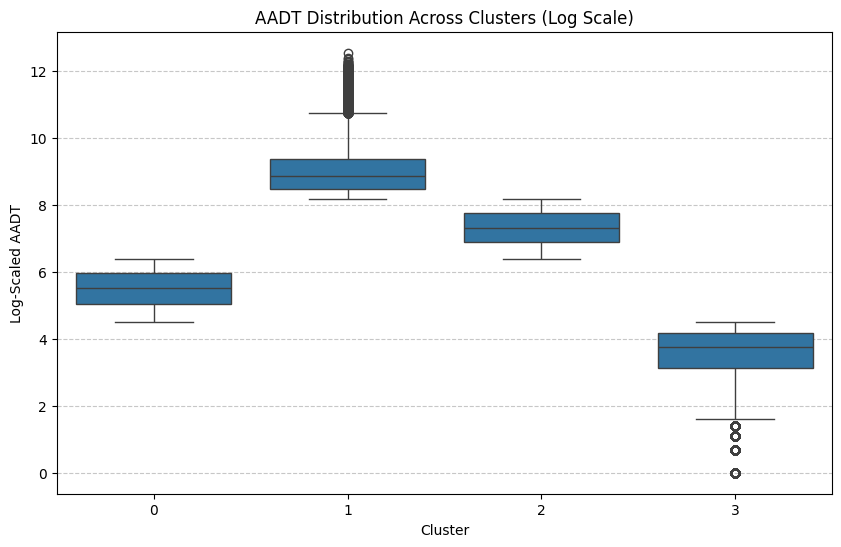

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Log-transform AADT for better scaling
df_combined["AADT_log"] = np.log1p(df_combined["AADT"])

# Create boxplot
sns.boxplot(x=df_combined["Cluster"], y=df_combined["AADT_log"])

plt.xlabel("Cluster")
plt.ylabel("Log-Scaled AADT")
plt.title("AADT Distribution Across Clusters (Log Scale)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_13780\1994338209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df_combined["Cluster"], y=df_combined["AADT_log"],


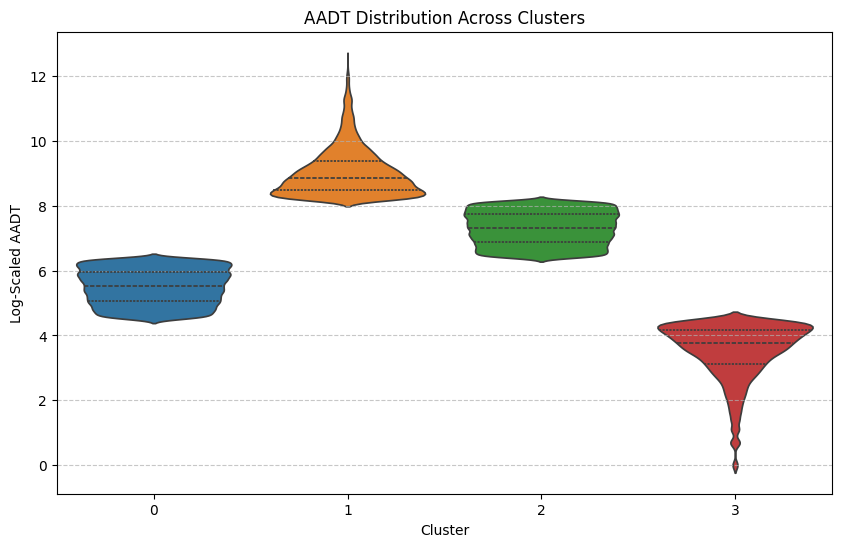

In [9]:
plt.figure(figsize=(10, 6))

# Custom colors for each cluster
palette_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red

sns.violinplot(x=df_combined["Cluster"], y=df_combined["AADT_log"], 
               inner="quartile", palette=palette_colors)

plt.xlabel("Cluster")
plt.ylabel("Log-Scaled AADT")
plt.title("AADT Distribution Across Clusters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



In [4]:
print(df_combined.groupby("Cluster")["Anomaly"].value_counts())

Cluster  Anomaly
0         1         41168
1         1         35670
         -1           413
2         1         49385
3         1         20524
         -1          1069
Name: count, dtype: int64


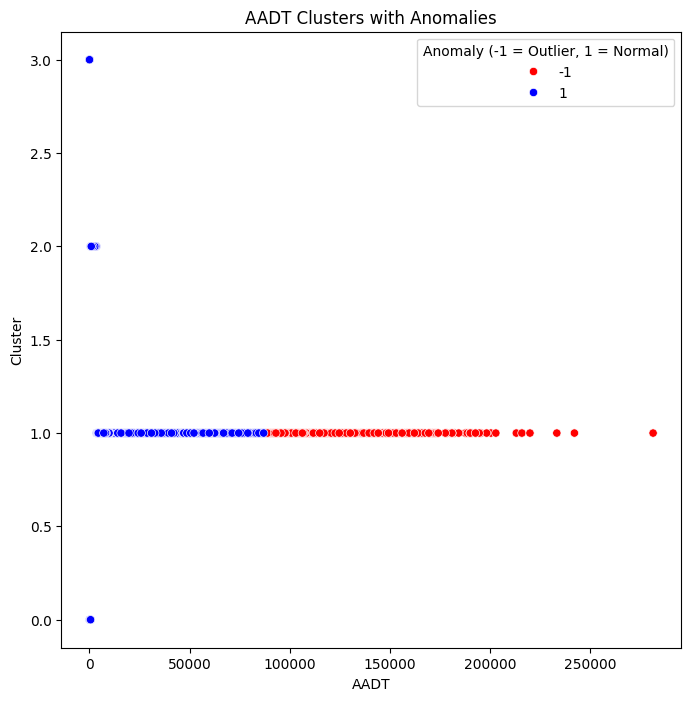

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_combined["AADT"], y=df_combined["Cluster"], hue=df_combined["Anomaly"], palette={1: "blue", -1: "red"})
plt.xlabel("AADT")
plt.ylabel("Cluster")
plt.title("AADT Clusters with Anomalies")
plt.legend(title="Anomaly (-1 = Outlier, 1 = Normal)")
plt.show()

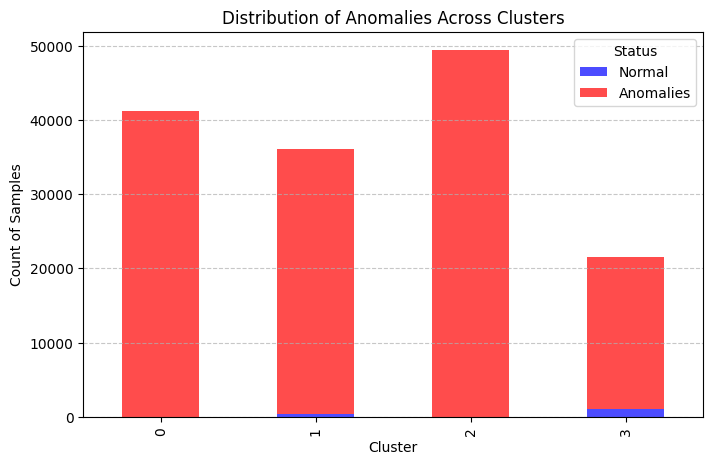

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count anomalies per cluster safely (ensuring missing values are handled)
anomaly_counts = df_combined.groupby("Cluster")["Anomaly"].value_counts().unstack().fillna(0)

# Rename columns dynamically based on available anomaly labels
anomaly_counts.columns = ["Normal" if 1 in anomaly_counts.columns else "Missing", 
                          "Anomalies" if -1 in anomaly_counts.columns else "Missing"]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
anomaly_counts.plot(kind="bar", stacked=True, color=["blue", "red"], alpha=0.7, ax=ax)

# Labels and title
plt.xlabel("Cluster")
plt.ylabel("Count of Samples")
plt.title("Distribution of Anomalies Across Clusters")
plt.legend(title="Status", labels=anomaly_counts.columns)
plt.grid(axis="y", linestyle="--", alpha=0.7)



